# 设置不同的learning rate 观察多层感知机的收敛情况

回调函数是一组在训练的特定阶段被调用的函数集，你可以使用回调函数来观察训练过程中网络内部的状态和统计信息。通过传递回调函数列表到模型的.fit()中，即可在给定的训练阶段调用该函数集中的函数。

【Tips】虽然我们称之为回调“函数”，但事实上Keras的回调函数是一个类，回调函数只是习惯性称呼

`keras.callbacks.Callback()` 这是回调函数的抽象类，定义新的回调函数必须继承自该类

- params：字典，训练参数集（如信息显示方法verbosity，batch大小，epoch数）
- model：keras.models.Model对象，为正在训练的模型的引用

回调函数以字典`logs`为参数，该字典包含了一系列与当前batch或epoch相关的信息。

目前，模型的`.fit()`中有下列参数会被记录到logs中：

- 在每个epoch的结尾处（on_epoch_end），`logs`将包含训练的正确率和误差，`acc`和`loss`，如果指定了验证集，还会包含验证集正确率和误差`val_acc`和`val_loss`，`val_acc`还额外需要在`.compile`中启用`metrics=['accuracy']`。

- 在每个batch的开始处（on_batch_begin）：`logs`包含`size`，即当前`batch`的样本数

- 在每个`batch`的结尾处（on_batch_end）：`logs`包含`loss`，若启用`accuracy`则还包含`acc`

In [2]:
%matplotlib inline

import keras
from keras.datasets import mnist 
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import RMSprop

Using TensorFlow backend.


载入mnist数据，第一次会自动下载，之后运行会载入本地文件。


keras中的mnist数据集已经被划分成了60,000个训练集，10,000个测试集的形式，按以下格式调用即可

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

查看一下数据格式，训练集一共有6万张，大小是28*28,单通道灰度图，测试集是1000张。标签是列向量

In [3]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape) 

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


可视化

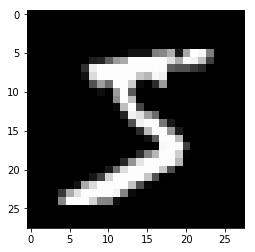

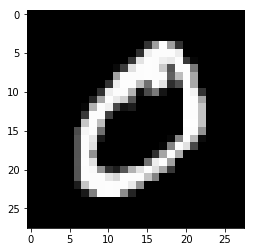

In [4]:
import matplotlib.pyplot as plt
im = plt.imshow(x_train[0],cmap='gray')
plt.show()
im2 = plt.imshow(x_train[1],cmap='gray')
plt.show()

将每一幅图像都转换为一个长向量，大小为28*28=784

In [5]:
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
x_train = x_train.astype('float32')
x_train = x_train.astype('float32')
print(x_train.shape) 

(60000, 784)


归一化，将图像的像素归到0~1

In [6]:
x_train = x_train / 255
x_test = x_test / 255

将label也转换成One-hot标签，这里直接用keras的预置的一个函数 keras.utils.to_categorical

In [7]:
print(y_train[0: 10])# 查看原始标签 0~9

[5 0 4 1 9 2 1 3 1 4]


In [8]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(y_train[0:10])#查看转换完毕的标签

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


开始构建模型，模型分包含两个隐层和一个输出层,都是全连接层，使用Sequential构建

其中隐层输出采用ReLU激活函数，Sequential的第一层要指定input_shape，要注意，这里的input_shape 是不包含batch大小的，就只是后面几维

In [9]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
#model.add(Dropout(0.2))
model.add(Dense(512, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(10, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()#这一句用来输出网络结构

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


配置模型，主要包括 
loss：loss计算方法（损失函数）

optimizer：优化函数

metrics：指定哪些量需要在训练及测试中关注，一般都会写accuracy

In [17]:
# 自定义callback类
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        
        plt.figure()
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()

In [13]:
history = LossHistory()

In [ ]:
# 学习率默认是 lr=0.001
model.compile(loss='categorical_crossentropy',
             optimizer = RMSprop(lr=0.001),
             metrics=['accuracy'])

In [14]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          validation_data=(x_test,y_test), 
          callbacks=[history])


Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 6s 93us/step - loss: 0.2955 - acc: 0.9120 - val_loss: 0.1177 - val_acc: 0.9619
Epoch 2/3
60000/60000 [==============================] - 5s 90us/step - loss: 0.1023 - acc: 0.9685 - val_loss: 0.0855 - val_acc: 0.9755
Epoch 3/3
60000/60000 [==============================] - 5s 88us/step - loss: 0.0672 - acc: 0.9792 - val_loss: 0.0752 - val_acc: 0.9763


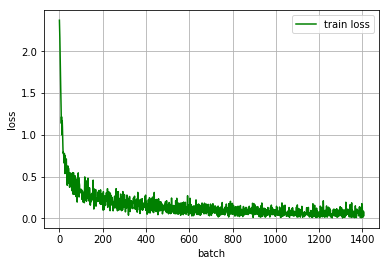

In [16]:
history.loss_plot('batch')

In [18]:
model.compile(loss='categorical_crossentropy',
             optimizer = RMSprop(lr=0.5),
             metrics=['accuracy'])

In [19]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          validation_data=(x_test,y_test), 
          callbacks=[history])


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 92us/step - loss: 10.3883 - acc: 0.1012 - val_loss: 10.3860 - val_acc: 0.1032
Epoch 2/3
60000/60000 [==============================] - 5s 90us/step - loss: 10.4105 - acc: 0.0993 - val_loss: 10.3860 - val_acc: 0.1032
Epoch 3/3
60000/60000 [==============================] - 5s 91us/step - loss: 10.4105 - acc: 0.0993 - val_loss: 10.3860 - val_acc: 0.1032


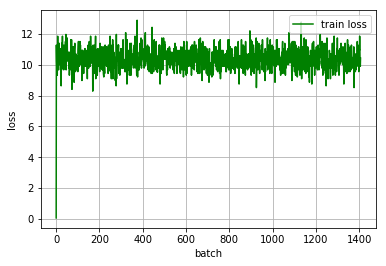

In [20]:
history.loss_plot('batch')